### 作業目的: 實作word2vec Skip-gram模型
在課程中了解如何搭建CBOW模型，這次的作業目的在於透過搭建Skip-gram模型來了解另外一種word2vec的架構。

Hint_1: 學員可以善用課程中以搭建好的function模組
Hint_2: Skip_gram所需的輸入資料與目標跟CBOW有些許不同，Skip_gram是由中間字詞預測上下文

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

# Current directory
print(os.getcwd())

# change directory
os.chdir('/content/drive/MyDrive/python_training/NLP100Days-part2/D13-word2vec-simple-lab/')
print(os.getcwd())

/content
/content/drive/MyDrive/python_training/NLP100Days-part2/D13-word2vec-simple-lab


In [3]:
# import modules
import numpy as np
from typing import List
from utils.utility import clip_grads, convert_one_hot, preprocess, Trainer
from utils.layers import Dense, SoftmaxWithCrossEntropy
from utils.optimizer import SGD

In [4]:
# use the same corpus as in the lecture
text = "I am studying Natural Language Processing now."

# define create_contexts_target function
def create_contexts_target(corpus: List, window_size: int=1):
    ###<your code>###    
    contexts = corpus[window_size:-window_size]
    targets = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                # skip target word itself
                continue
            cs.append(corpus[idx + t])
        targets.append(cs)
    return np.array(contexts), np.array(targets)

# transform corpus to contexts and targets pair
corpus, word2idx, idx2word = preprocess([text])
contexts, targets= create_contexts_target(corpus[0], window_size=1)
contexts, targets

(array([3, 5, 7, 1, 6, 0]), array([[4, 5],
        [3, 7],
        [5, 1],
        [7, 6],
        [1, 0],
        [6, 2]]))

In [5]:
# transform contexts and targets to one-hot encoding
### <your code> ###
def convert_one_hot(corpus, vocab_size):
    N = corpus.shape[0] ##corpus= [[1, 5, 3, 0, 6, 2, 4, 7]]

    if corpus.ndim == 1: ## 只有1個句子
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1
    elif corpus.ndim == 2:## 2個句子以上
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [6]:
contexts = convert_one_hot(contexts, len(word2idx))
targets = convert_one_hot(targets, len(word2idx))
contexts, targets

(array([[0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0]], dtype=int32),
 array([[[0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0]],
 
        [[0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1]],
 
        [[0, 0, 0, 0, 0, 1, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 1, 0]],
 
        [[0, 1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 1, 0, 0, 0, 0, 0]]], dtype=int32))

In [7]:
# define Skip-gram model
class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size):
        V, H = vocab_size, hidden_size
        self.window_size = window_size

        # initialize weights
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # create layers
        self.in_layer = Dense(W_in)
        self.out_layer = Dense(W_out)
        self.loss_layers = [SoftmaxWithCrossEntropy() for i in range(window_size*2)]

        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # word vector matrix
        self.word_vecs = W_in

    def forward(self, contexts, targets):
        h = self.in_layer.forward(contexts)
        s = self.out_layer.forward(h)
        
        loss = sum([self.loss_layers[i].forward(s, targets[:, i]) for i in range(self.window_size*2)])
        return loss


    def backward(self, dout=1):
        ds = sum([self.loss_layers[i].backward(dout) for i in range(self.window_size*2)])
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        
        return None


In [8]:
# start training

# configurations
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

# define model
skip_gram = SkipGram(vocab_size=len(word2idx), hidden_size=hidden_size, window_size=window_size)

sgd_optimizer = SGD()
trainer = Trainer(skip_gram, sgd_optimizer)

# start training
trainer.fit(contexts, targets, max_epoch, batch_size)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 1, Iteration: 1/2, Loss: 4.159002032049327
Epoch: 2, Iteration: 1/2, Loss: 4.158928510705561
Epoch: 3, Iteration: 1/2, Loss: 4.158779603559765
Epoch: 4, Iteration: 1/2, Loss: 4.1588527401781175
Epoch: 5, Iteration: 1/2, Loss: 4.158750670021593
Epoch: 6, Iteration: 1/2, Loss: 4.1587343661066685
Epoch: 7, Iteration: 1/2, Loss: 4.158622890479655
Epoch: 8, Iteration: 1/2, Loss: 4.158613686730996
Epoch: 9, Iteration: 1/2, Loss: 4.158468774558987
Epoch: 10, Iteration: 1/2, Loss: 4.158612977185973
Epoch: 11, Iteration: 1/2, Loss: 4.158392310236827
Epoch: 12, Iteration: 1/2, Loss: 4.1583138960284405
Epoch: 13, Iteration: 1/2, Loss: 4.158293245609562
Epoch: 14, Iteration: 1/2, Loss: 4.158329386154207
Epoch: 15, Iteration: 1/2, Loss: 4.158069519059486
Epoch: 16, Iteration: 1/2, Loss: 4.1578825310241365
Epoch: 17, Iteration: 1/2, Loss: 4.158196196633781
Epoch: 18, Iteration: 1/2, Loss: 4.157638239798055
Epoch: 19, Iteration: 1/2, Loss: 4.157560882435533
Epoch: 20, Iteration: 1/2, Loss: 4.1

  9%|▉         | 88/1000 [00:00<00:01, 872.77it/s]

Epoch: 55, Iteration: 1/2, Loss: 4.105166080420442
Epoch: 56, Iteration: 1/2, Loss: 4.081377621013953
Epoch: 57, Iteration: 1/2, Loss: 4.091476768950913
Epoch: 58, Iteration: 1/2, Loss: 4.061866881054475
Epoch: 59, Iteration: 1/2, Loss: 4.066098568621267
Epoch: 60, Iteration: 1/2, Loss: 4.049892141874402
Epoch: 61, Iteration: 1/2, Loss: 4.026308963716838
Epoch: 62, Iteration: 1/2, Loss: 4.035016717151623
Epoch: 63, Iteration: 1/2, Loss: 4.017457804878014
Epoch: 64, Iteration: 1/2, Loss: 3.988753672202548
Epoch: 65, Iteration: 1/2, Loss: 3.9834988768324218
Epoch: 66, Iteration: 1/2, Loss: 3.9734566605708985
Epoch: 67, Iteration: 1/2, Loss: 3.9140638120468987
Epoch: 68, Iteration: 1/2, Loss: 3.9095575059913195
Epoch: 69, Iteration: 1/2, Loss: 3.8857688480800454
Epoch: 70, Iteration: 1/2, Loss: 3.8635630100950333
Epoch: 71, Iteration: 1/2, Loss: 3.820745595361177
Epoch: 72, Iteration: 1/2, Loss: 3.75738308385728
Epoch: 73, Iteration: 1/2, Loss: 3.834849533288792
Epoch: 74, Iteration: 1/2,

 18%|█▊        | 180/1000 [00:00<00:00, 873.50it/s]

Epoch: 181, Iteration: 1/2, Loss: 1.4698779817914034
Epoch: 182, Iteration: 1/2, Loss: 1.488609665570749
Epoch: 183, Iteration: 1/2, Loss: 1.4794124955046941
Epoch: 184, Iteration: 1/2, Loss: 1.466454996363436
Epoch: 185, Iteration: 1/2, Loss: 1.475865796479309
Epoch: 186, Iteration: 1/2, Loss: 1.4808659019705288
Epoch: 187, Iteration: 1/2, Loss: 1.4720778416372062
Epoch: 188, Iteration: 1/2, Loss: 1.470215768538882
Epoch: 189, Iteration: 1/2, Loss: 1.4710971277670712
Epoch: 190, Iteration: 1/2, Loss: 1.4658544577592627
Epoch: 191, Iteration: 1/2, Loss: 1.4596421256689176
Epoch: 192, Iteration: 1/2, Loss: 1.4726362059794438
Epoch: 193, Iteration: 1/2, Loss: 1.455376541906756
Epoch: 194, Iteration: 1/2, Loss: 1.4794016982969929
Epoch: 195, Iteration: 1/2, Loss: 1.446621668978785
Epoch: 196, Iteration: 1/2, Loss: 1.4673666920192665
Epoch: 197, Iteration: 1/2, Loss: 1.4687975351530935
Epoch: 198, Iteration: 1/2, Loss: 1.449037988249971
Epoch: 199, Iteration: 1/2, Loss: 1.4570011022175595


 35%|███▌      | 353/1000 [00:00<00:00, 869.32it/s]

Epoch: 228, Iteration: 1/2, Loss: 1.4447847658782722
Epoch: 229, Iteration: 1/2, Loss: 1.4265475516900215
Epoch: 230, Iteration: 1/2, Loss: 1.4424094073106941
Epoch: 231, Iteration: 1/2, Loss: 1.4347137654975288
Epoch: 232, Iteration: 1/2, Loss: 1.423271446703045
Epoch: 233, Iteration: 1/2, Loss: 1.4382401800901057
Epoch: 234, Iteration: 1/2, Loss: 1.4274281443003822
Epoch: 235, Iteration: 1/2, Loss: 1.4353743642473995
Epoch: 236, Iteration: 1/2, Loss: 1.4323723928146999
Epoch: 237, Iteration: 1/2, Loss: 1.4306945924438002
Epoch: 238, Iteration: 1/2, Loss: 1.4337711789608276
Epoch: 239, Iteration: 1/2, Loss: 1.4295630014793104
Epoch: 240, Iteration: 1/2, Loss: 1.4214163400745017
Epoch: 241, Iteration: 1/2, Loss: 1.4338995232425882
Epoch: 242, Iteration: 1/2, Loss: 1.424420613278941
Epoch: 243, Iteration: 1/2, Loss: 1.4314201448384163
Epoch: 244, Iteration: 1/2, Loss: 1.4286163218829764
Epoch: 245, Iteration: 1/2, Loss: 1.4306187884457222
Epoch: 246, Iteration: 1/2, Loss: 1.423773027518

 53%|█████▎    | 529/1000 [00:00<00:00, 875.11it/s]

Epoch: 407, Iteration: 1/2, Loss: 1.4000528128867467
Epoch: 408, Iteration: 1/2, Loss: 1.401785604843309
Epoch: 409, Iteration: 1/2, Loss: 1.4017570534612336
Epoch: 410, Iteration: 1/2, Loss: 1.4000481827534896
Epoch: 411, Iteration: 1/2, Loss: 1.399359380010418
Epoch: 412, Iteration: 1/2, Loss: 1.4020103310648988
Epoch: 413, Iteration: 1/2, Loss: 1.400333424084042
Epoch: 414, Iteration: 1/2, Loss: 1.3994494238304591
Epoch: 415, Iteration: 1/2, Loss: 1.4015371095712559
Epoch: 416, Iteration: 1/2, Loss: 1.3995458900222646
Epoch: 417, Iteration: 1/2, Loss: 1.4014365421898232
Epoch: 418, Iteration: 1/2, Loss: 1.4009356186082984
Epoch: 419, Iteration: 1/2, Loss: 1.3993367310268363
Epoch: 420, Iteration: 1/2, Loss: 1.4001709720771358
Epoch: 421, Iteration: 1/2, Loss: 1.4003176617629651
Epoch: 422, Iteration: 1/2, Loss: 1.398811550873901
Epoch: 423, Iteration: 1/2, Loss: 1.401061722792525
Epoch: 424, Iteration: 1/2, Loss: 1.3999392558214994
Epoch: 425, Iteration: 1/2, Loss: 1.399052603045917

 70%|███████   | 704/1000 [00:00<00:00, 876.05it/s]

Epoch: 596, Iteration: 1/2, Loss: 1.3941358229413012
Epoch: 597, Iteration: 1/2, Loss: 1.3941319228109652
Epoch: 598, Iteration: 1/2, Loss: 1.3939972644291005
Epoch: 599, Iteration: 1/2, Loss: 1.3942460772382574
Epoch: 600, Iteration: 1/2, Loss: 1.3940563618635502
Epoch: 601, Iteration: 1/2, Loss: 1.393645092840167
Epoch: 602, Iteration: 1/2, Loss: 1.3948683557156396
Epoch: 603, Iteration: 1/2, Loss: 1.393065647074379
Epoch: 604, Iteration: 1/2, Loss: 1.3944237542770028
Epoch: 605, Iteration: 1/2, Loss: 1.3946178360125934
Epoch: 606, Iteration: 1/2, Loss: 1.3933206637299285
Epoch: 607, Iteration: 1/2, Loss: 1.39418273110023
Epoch: 608, Iteration: 1/2, Loss: 1.3943122399867574
Epoch: 609, Iteration: 1/2, Loss: 1.393391053527358
Epoch: 610, Iteration: 1/2, Loss: 1.3938616918433588
Epoch: 611, Iteration: 1/2, Loss: 1.3938843091061308
Epoch: 612, Iteration: 1/2, Loss: 1.394235017745851
Epoch: 613, Iteration: 1/2, Loss: 1.3934290653717194
Epoch: 614, Iteration: 1/2, Loss: 1.393932825223948


 88%|████████▊ | 875/1000 [00:01<00:00, 845.73it/s]

Epoch: 770, Iteration: 1/2, Loss: 1.3913301149881188
Epoch: 771, Iteration: 1/2, Loss: 1.3913992475888675
Epoch: 772, Iteration: 1/2, Loss: 1.3921745258696494
Epoch: 773, Iteration: 1/2, Loss: 1.3913871676397287
Epoch: 774, Iteration: 1/2, Loss: 1.391630891472595
Epoch: 775, Iteration: 1/2, Loss: 1.3917128543766593
Epoch: 776, Iteration: 1/2, Loss: 1.3914634349082697
Epoch: 777, Iteration: 1/2, Loss: 1.3916933861624132
Epoch: 778, Iteration: 1/2, Loss: 1.3915915557457688
Epoch: 779, Iteration: 1/2, Loss: 1.3918398061343833
Epoch: 780, Iteration: 1/2, Loss: 1.391578659844508
Epoch: 781, Iteration: 1/2, Loss: 1.391568935027405
Epoch: 782, Iteration: 1/2, Loss: 1.3913092492519123
Epoch: 783, Iteration: 1/2, Loss: 1.3916229091019168
Epoch: 784, Iteration: 1/2, Loss: 1.3914726795508736
Epoch: 785, Iteration: 1/2, Loss: 1.3915285140191114
Epoch: 786, Iteration: 1/2, Loss: 1.391846812786019
Epoch: 787, Iteration: 1/2, Loss: 1.391161845795564
Epoch: 788, Iteration: 1/2, Loss: 1.391511791075283

100%|██████████| 1000/1000 [00:01<00:00, 851.51it/s]

Epoch: 940, Iteration: 1/2, Loss: 1.3904910910983366
Epoch: 941, Iteration: 1/2, Loss: 1.3904795184223517
Epoch: 942, Iteration: 1/2, Loss: 1.3901522388904872
Epoch: 943, Iteration: 1/2, Loss: 1.390408632306463
Epoch: 944, Iteration: 1/2, Loss: 1.3902754592961697
Epoch: 945, Iteration: 1/2, Loss: 1.390147489510178
Epoch: 946, Iteration: 1/2, Loss: 1.3902749156655798
Epoch: 947, Iteration: 1/2, Loss: 1.3903749475487026
Epoch: 948, Iteration: 1/2, Loss: 1.3905762867326552
Epoch: 949, Iteration: 1/2, Loss: 1.3902340752161888
Epoch: 950, Iteration: 1/2, Loss: 1.390293457265794
Epoch: 951, Iteration: 1/2, Loss: 1.390321339767718
Epoch: 952, Iteration: 1/2, Loss: 1.3902922535524396
Epoch: 953, Iteration: 1/2, Loss: 1.3905322618211735
Epoch: 954, Iteration: 1/2, Loss: 1.3900335629371154
Epoch: 955, Iteration: 1/2, Loss: 1.3902644063063296
Epoch: 956, Iteration: 1/2, Loss: 1.3903442432511885
Epoch: 957, Iteration: 1/2, Loss: 1.3902118840447777
Epoch: 958, Iteration: 1/2, Loss: 1.39000230512749

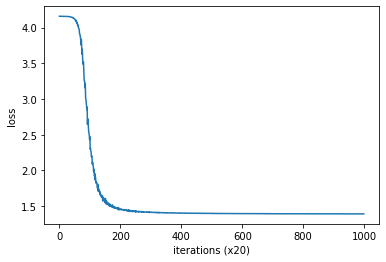

In [9]:
trainer.plot()

In [10]:
# check skip-gram results
### <your code> ###
word_vecs = skip_gram.word_vecs
for word_id, word in idx2word.items():
    print(word, word_vecs[word_id])


now [ 0.98663497  0.8711612  -0.22609812  2.290029    0.93089914]
language [-0.34652188  2.8303218   0.41004536  0.9592476  -0.7332612 ]
. [ 0.00032336 -0.01121719 -0.00064904  0.00334205  0.00627654]
am [-0.40278414 -2.4895418   0.6373294   0.86013854 -0.80267334]
i [-0.01029491 -0.0168495   0.0051203   0.00341782  0.03141338]
studying [-1.7741147   0.97150886 -0.08772886 -1.0290977  -1.7394452 ]
processing [ 0.80431247  0.47838637 -0.84642833 -2.0562935   1.4735254 ]
natural [ 1.0698771  -2.3187208   0.51766837 -1.4119588   0.96732485]


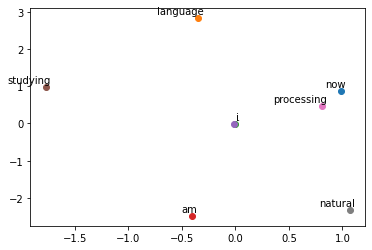

In [11]:

import matplotlib.pyplot as plt
for i, w in idx2word.items():
    vectors = skip_gram.word_vecs
    x,y = float(vectors[i][0]),float(vectors[i][1])
    plt.scatter(x,y)
    plt.annotate(w, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()